In [1]:
import pandas as pd
import tensorflow as tf

DATA_PATH = '/home/kshipra/work/major/ml experiments/data/manually_combined.xlsx'

eos = pd.read_excel(DATA_PATH, sheet_name='all_stacked_eos')
sentinel = pd.read_excel(DATA_PATH, sheet_name='all_stacked_sentinel')
combined = pd.read_excel(DATA_PATH, sheet_name='eos_sent_combined')

len(eos), len(sentinel), len(combined)

2025-09-22 20:14:16.286755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(747, 796, 747)

In [2]:
X_cols = ['VH', 'VV', 'HH', 'HV', 'Angle']
y_col = ['SM (Combined)']

num_features = len(X_cols)

In [3]:
combined = combined[combined['SM (Combined)'] < 150]

combined

,VH,VV,Angle,SM (Sent),HH,HV,SM (EOS),SM (Combined),Unnamed: 8,Latitude (S),Longitude (S),Latitude (E),Longitude (E),Lat Diff,Long Diff,SM Diff
0,-14.947200,-10.379400,40.366800,20.6,-7.38713,-15.09099,24.4,22.50,NaN,22.526048,72.765011,22.526048,72.765011,0.000000,0.000000,-3.8
1,-16.361200,-11.299400,41.008800,25.8,-6.25740,-12.05392,41.0,33.40,NaN,22.525481,72.765028,22.525481,72.765028,0.000000,0.000000,-15.2
2,-16.168800,-10.992000,42.359800,28.9,-8.44134,-16.46069,25.3,27.10,NaN,22.525423,72.765663,22.525423,72.765663,0.000000,0.000000,3.6
3,-15.630700,-8.829090,42.982700,4.1,-2.85467,-17.00499,53.7,28.90,NaN,22.525999,72.765663,22.525999,72.765663,0.000000,0.000000,-49.6
4,-15.130900,-10.333000,41.434700,35.3,-6.88868,-12.32378,53.4,44.35,NaN,22.525563,72.765399,22.525563,72.765399,0.000000,0.000000,-18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,-15.603123,-10.557852,42.709682,30.2,-8.69274,-14.15688,26.8,28.50,NaN,22.505581,72.764064,22.523640,72.766727,-0.018059,-0.002663,3.4
743,-16.321512,-11.300431,42.176147,38.3,-6.48271,-15.56076,32.8,35.55,NaN,22.505961,72.764083,22.523657,72.766016,-0.017696,-0.001933,5.5
744,-15.585269,-11.489754,42.523727,20.0,-6.20660,-14.73141,34.8,27.40,NaN,22.506133,72.763434,22.524255,72.766024,-0.018122,-0.002590,-14.8
745,-16.052544,-10.954885,42.562408,39.7,-9.43414,-20.52987,27.8,33.75,NaN,22.505784,72.763859,22.524229,72.766601,-0.018445,-0.002742,11.9


In [4]:
from model_experiments import PredictionIntervalWithTubeLoss
from tensorflow import keras

tf.keras.backend.clear_session()

model1 = tf.keras.Sequential([
    # Input layer
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(16, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(8, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])

model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(8, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])

model3 = tf.keras.Sequential([
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(4, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])

## Exp 1

Epochs: 100%|██████████| 20/20 [00:02<00:00,  6.81epoch/s, loss=0.6343, val_loss=0.6683] 


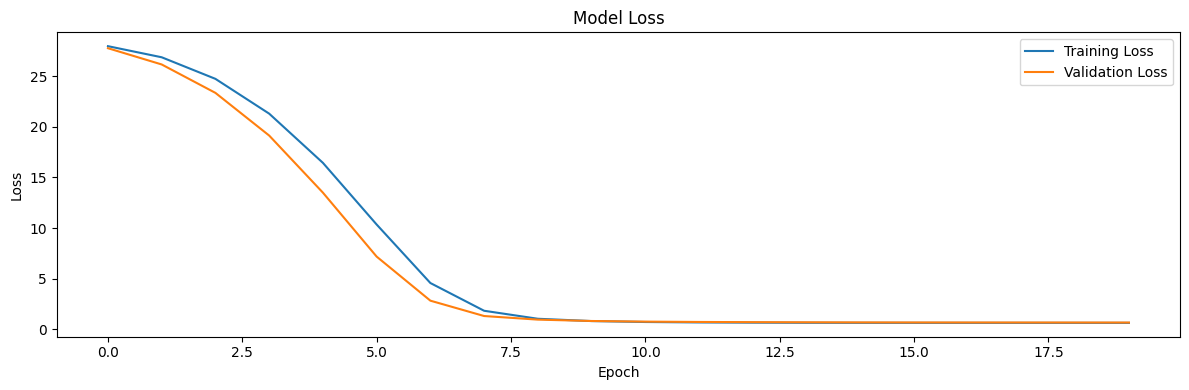

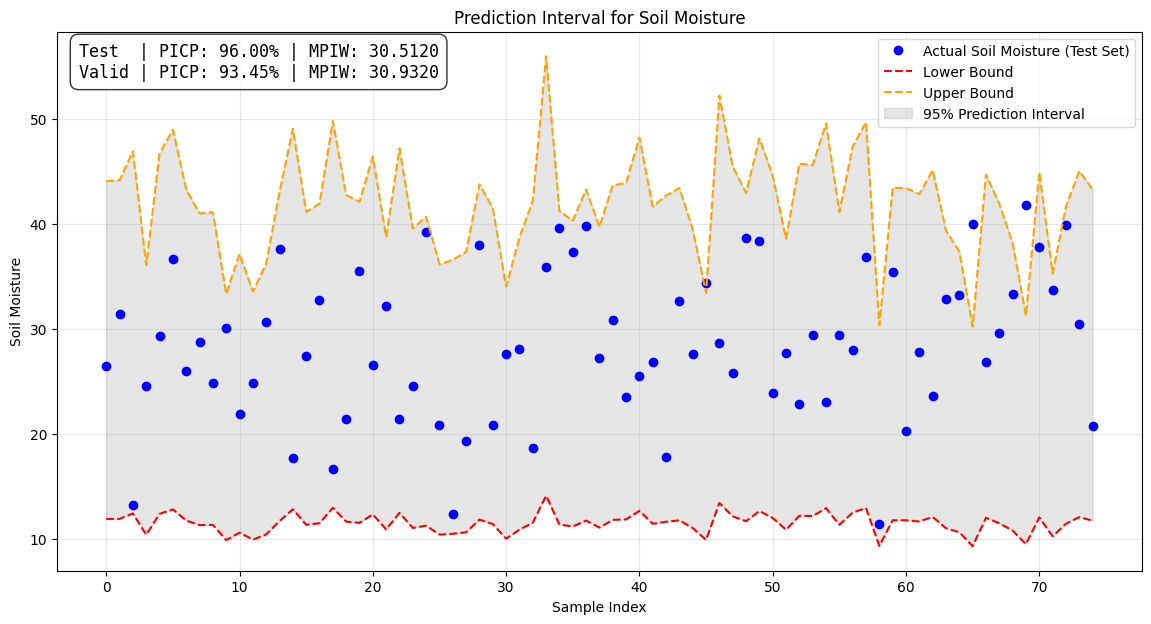

In [5]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

pi = PredictionIntervalWithTubeLoss(combined, features=X_cols, target=y_col[0])
pi.train_model(model3, optimizer=opt, num_epochs=20)
pi.plot_losses()
pi.plot_prediction_interval()

## Exp 2

Epochs:  44%|████▍     | 44/100 [00:05<00:06,  8.04epoch/s, loss=0.6294, val_loss=0.6616] 


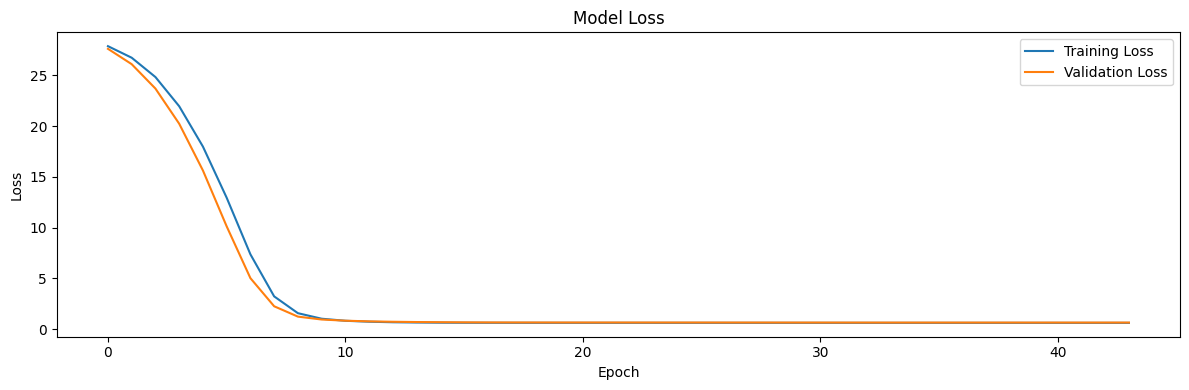

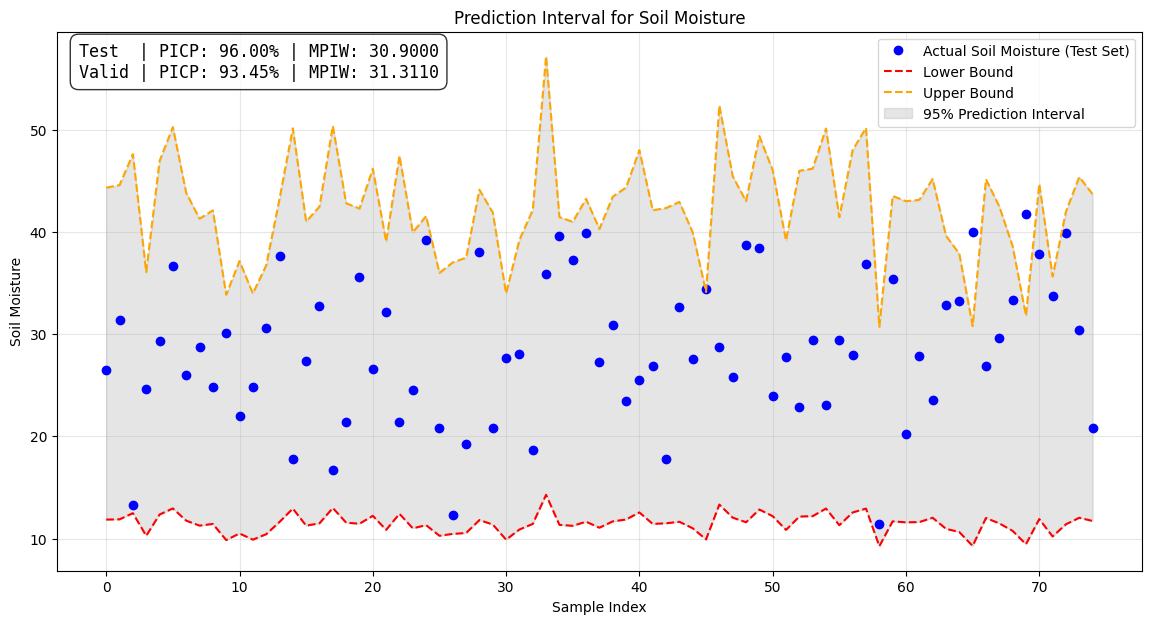

In [6]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

pi= PredictionIntervalWithTubeLoss(combined, features=X_cols, target=y_col[0])
pi.train_model(model2, optimizer=opt)
pi.plot_losses()
pi.plot_prediction_interval()

## Exp 3

Epochs:  13%|█▎        | 13/100 [00:02<00:17,  4.89epoch/s, loss=0.8293, val_loss=0.7460] 


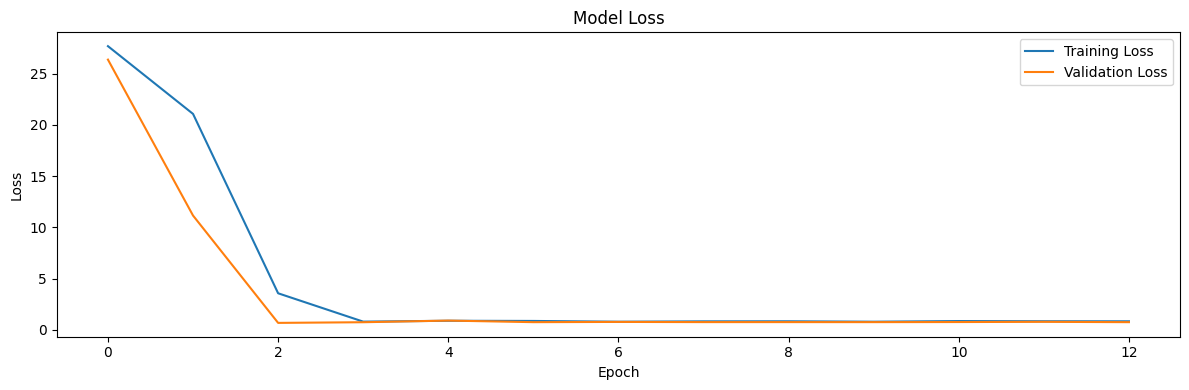

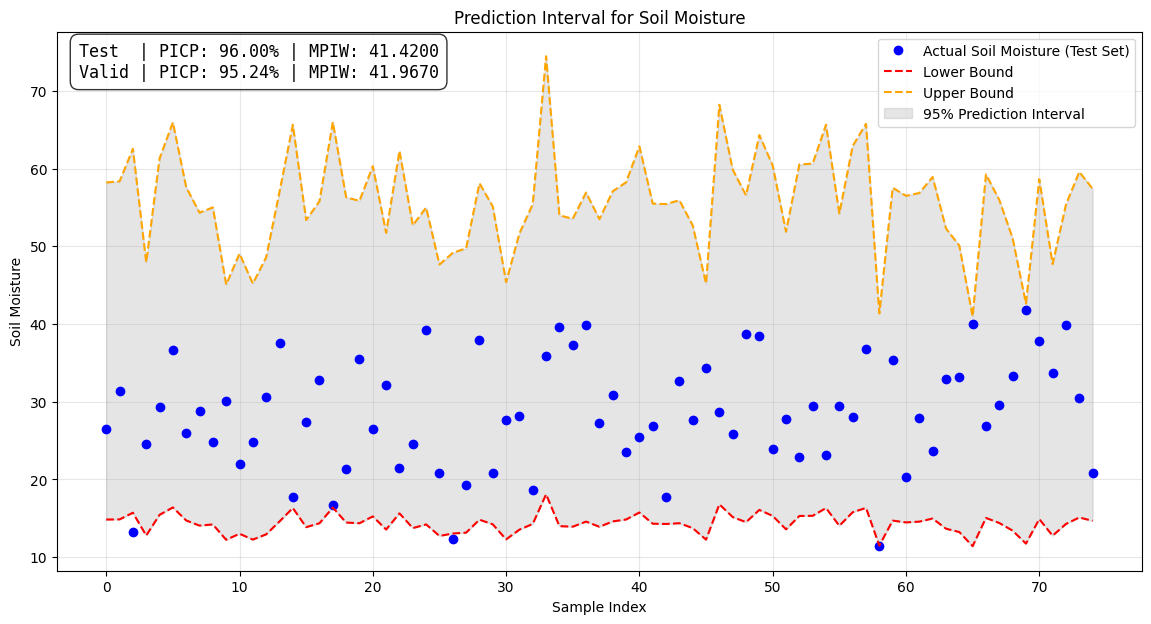

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

pi= PredictionIntervalWithTubeLoss(combined, features=X_cols, target=y_col[0])
pi.train_model(model1, optimizer=opt)
pi.plot_losses()
pi.plot_prediction_interval()